# 1. ETL, Extracción Transformación y Carga de Datos

En este proceso extraemos los datos necesarios y los limpiamos para tenerlos en formato correcto para nuestros fines.

#### 1.0 Importamos librerías, definimos funciones y constantes

In [187]:
import pandas as pd
import json
import ast
import warnings
from io import StringIO
import hashlib
import matplotlib.pyplot as plt

from typing import List, Dict
import base64, csv

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import plotly.express as px
import seaborn as sns
import importlib
from wordcloud import WordCloud


warnings.filterwarnings('ignore')

In [2]:

def showPie(columna):
  count_values = pd.Series(columna).value_counts()
  if len(count_values) > 15:
    count_values = count_values.iloc[0:15]
  datos = pd.DataFrame({"valor":count_values.index, "ocurrencia": count_values.values})

  plt.title(columna.name)
  plt.pie(datos["ocurrencia"], labels=datos['valor'], autopct='%1.1f%%')
  plt.show()

def concatenar(data_1, data_2,  axis=1):
  return pd.concat([data_1, data_2], axis=axis)

def contar_nulos(data):
  return data.isna().sum()

def mapear(columna: pd.Series, mapa={'NO': 0, 'SI':1}):
  return columna.map(mapa)

def showPiePx(columna, max=15):
  count_values = pd.Series(columna).value_counts()
  if len(count_values) > max:
    count_values = count_values.iloc[0:max]
  datos = pd.DataFrame({"valor":count_values.index, "ocurrencia": count_values.values})
  fig = px.pie(datos, values='ocurrencia', names='valor', title=columna.name)
  fig.update_traces(textposition='outside', textinfo='percent+label')
  fig.show()
  
def nulos_filas(data):
    # return pd.DataFrame(data.isna().sum(axis=1).value_counts().sort_values(ascending=False).reset_index().values, columns=['cant_col_nulas', 'cantidad'])
    return pd.DataFrame(data.isna().sum(axis=1).value_counts().reset_index().values, columns=['cant_col_nulas', 'cantidad'])
  
def limpiar_funny(x: str)->int:
  temp = len(x)
  if temp == 0:
    return 0
  n = x.split(' ')[0]
  n = n.replace(',','')
  return int(n)

def limpiar_helpful(x: str)->float:
  if x == 'No ratings yet':
    return 1
  ns = x.split(' ')[:3]
  n1 = float(ns[0].replace(',',''))
  n2 = float(ns[2].replace(',',''))
  if ns[0] == 0:
    return -1.0
  return (n1/n2)

import string

def limpiar_posted(posted):
  posted = posted[7:-1].translate(str.maketrans('', '', string.punctuation))
  temp = posted.split()
  mes = temp[0]
  dia = temp[1]
  try:
    anio = temp[2]
  except:
    anio = '2016'

  return pd.to_datetime("-".join([dia, mes, anio]))

  import matplotlib.pyplot as plt

def showPie(columna, max=15):
  count_values = pd.Series(columna).value_counts()
  if len(count_values) > max:
    count_values = count_values.iloc[0:max]
  datos = pd.DataFrame({"valor":count_values.index, "ocurrencia": count_values.values})

  plt.title(columna.name)
  plt.pie(datos["ocurrencia"], labels=datos['valor'], autopct='%1.1f%%')
  plt.show()

In [3]:
URL_STEAM_GAMES = 'datasets/origin/output_steam_games.json'
URL_USERS_ITEMS = 'datasets/origin/australian_users_items.json'
URL_USERS_REVIEWS = 'datasets/origin/australian_user_reviews.json'

# 1 Dataset Steam Games

## 1.1 ETL

### 1.1.1 Leer archivo JSON

Ya que el archivo se encuentra en formato JSON, con llamar a la función built-in ```read_json()``` podemos crear un ```DataFrame``` para leer los valores.

In [4]:
df_games_all = pd.read_json(URL_STEAM_GAMES, lines=True)

### 1.1.2 Análisis de Valores Nulos

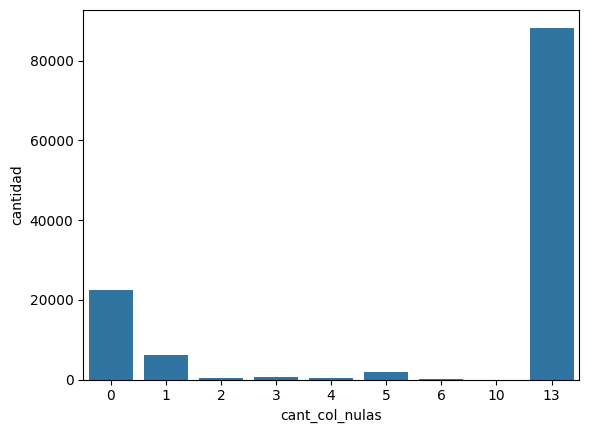

In [5]:
# Devuelve la cantidad filas que tienen la por cantidad de columnas nulas, es decir, 
# hay 88.310 filas que tienen 13 valores nulos, hay 22.530 filas que tienen 0 valores nulos

sns.barplot(x=nulos_filas(df_games_all).cant_col_nulas, y=nulos_filas(df_games_all).cantidad)
plt.show()

Revisando los valores nulos a lo largo del eje 1, vemos que hay un número muy grande (88310) de filas completamente vacías, ya que tiene 13 columnas el dataset y la cuenta de nulos es igual a ese valor. Por lo tanto, se recorta 
hasta n-1 valores nulos, es decir, como mínimo tiene que tener una columna no nula.

In [6]:
# Cantidad de Columnas
N = len(df_games_all.columns)

# Recorte de filas con valores nulos
df_games = df_games_all.drop( df_games_all[df_games_all.isna().sum(axis=1) > (N - 1) ].index)

### 1.1.3 Verificar duplicados

In [7]:
# Utilizamos una funcion de hash para verificar los duplicados por fila

# Es necesario convertrir a ```str``` los objetos
df_str = df_games.astype(str).duplicated()

print(f'Cantidad de filas duplicadas: {df_str.sum()}')


Cantidad de filas duplicadas: 0


### 1.1.4 Analizar todas las columnas para quitar redundancias e información no útil para el análisis

In [8]:
df_games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32135 entries, 88310 to 120444
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   publisher     24083 non-null  object 
 1   genres        28852 non-null  object 
 2   app_name      32133 non-null  object 
 3   title         30085 non-null  object 
 4   url           32135 non-null  object 
 5   release_date  30068 non-null  object 
 6   tags          31972 non-null  object 
 7   reviews_url   32133 non-null  object 
 8   specs         31465 non-null  object 
 9   price         30758 non-null  object 
 10  early_access  32135 non-null  float64
 11  id            32133 non-null  float64
 12  developer     28836 non-null  object 
dtypes: float64(2), object(11)
memory usage: 3.2+ MB


Vistazo de valores Nulos

In [9]:
pd.DataFrame(df_games.isna().sum()).T

,publisher,genres,app_name,title,url,release_date,tags,reviews_url,specs,price,early_access,id,developer
0,8052,3283,2,2050,0,2067,163,2,670,1377,0,2,3299


Las columnas ```title``` y ```app_name``` parecen contener lo mismo, comparamos

In [10]:
cantidad_filas = 0
cantidad_coincidencias = 0

for i in df_games.index:
    cantidad_filas += 1
    if (df_games.loc[i]['app_name'] == df_games.loc[i]['title']) and (not pd.isna(df_games.loc[i]['title'])):
        cantidad_coincidencias += 1

print(f'Porcentaje de Coincidencias: {(cantidad_coincidencias / cantidad_filas)*100:.2f} %')

Porcentaje de Coincidencias: 91.89 %


In [11]:
# Conteo de valores Nulos para cada columnas

pd.DataFrame(df_games[['title','app_name']].isna().sum().T, columns=['Cantidad de Nulos'])


,Cantidad de Nulos
title,2050
app_name,2


Teniendo en cuenta que la alta similitud de ambas columnas y que la columna ```app_name``` posee significativamente menos valores nulos, asumimos que dicha columna aporta más información, razón que nos permite prescindir de ```title```.

Preview de columnas deseadas

In [12]:
df_games.url.head(3), df_games.reviews_url.head(3), df_games.specs.head(3), df_games.publisher.head(3), df_games.developer.head(3)

(88310    http://store.steampowered.com/app/761140/Lost_...
 88311    http://store.steampowered.com/app/643980/Ironb...
 88312    http://store.steampowered.com/app/670290/Real_...
 Name: url, dtype: object,
 88310    http://steamcommunity.com/app/761140/reviews/?...
 88311    http://steamcommunity.com/app/643980/reviews/?...
 88312    http://steamcommunity.com/app/670290/reviews/?...
 Name: reviews_url, dtype: object,
 88310                                      [Single-player]
 88311    [Single-player, Multi-player, Online Multi-Pla...
 88312    [Single-player, Multi-player, Online Multi-Pla...
 Name: specs, dtype: object,
 88310           Kotoshiro
 88311    Making Fun, Inc.
 88312        Poolians.com
 Name: publisher, dtype: object,
 88310           Kotoshiro
 88311    Secret Level SRL
 88312        Poolians.com
 Name: developer, dtype: object)

Las columnas ```url```, ```reviewes_url```, ```specs``` contienen información considerada superflua para el análisis, ```publisher``` duplica información, al igual que ```early_access```.

In [13]:
columnas_a_quitar = ['title','url','reviews_url', 'early_access', 'publisher', 'specs']

In [14]:
df_games.drop(columnas_a_quitar, axis=1, inplace=True)

Reorganizamos las columnas a comodidad

In [15]:
df_games = df_games[['id','app_name', 'genres', 'release_date', 'tags', 'price', 'developer']]

In [16]:
df_games.head(3)

,id,app_name,genres,release_date,tags,price,developer
88310,761140.0,Lost Summoner Kitty,"[Action, Casual, Indie, Simulation, Strategy]",2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",4.99,Kotoshiro
88311,643980.0,Ironbound,"[Free to Play, Indie, RPG, Strategy]",2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",Free To Play,Secret Level SRL
88312,670290.0,Real Pool 3D - Poolians,"[Casual, Free to Play, Indie, Simulation, Sports]",2017-07-24,"[Free to Play, Simulation, Sports, Casual, Ind...",Free to Play,Poolians.com


Seguimos trabajando con las columnas

#### 1.1.4.1. ```App_Name```

In [17]:
# Buscamos nulos
df_games[df_games.app_name.isna()]

,id,app_name,genres,release_date,tags,price,developer
88384,NaN,None,None,None,None,19.99,None
90890,317160.0,None,"[Action, Indie]",2014-08-26,"[Action, Indie]",None,None


In [18]:
try:
    df_games.drop(88384, inplace=True)
except:
    print('No encontrado')

Buscando en la información duplicada que no usaremos para el análisis, pero la tenemos disponibles, conseguimos el valor en la columna ```title```, ya descartada, pero nos ayudó a obtener la info de estos nulos.

In [19]:
df_games.loc[90890, 'app_name'] = 'Duet'
df_games.loc[90890]

id                     317160.0
app_name                   Duet
genres          [Action, Indie]
release_date         2014-08-26
tags            [Action, Indie]
price                      None
developer                  None
Name: 90890, dtype: object

#### 1.1.4.2 ```Id```

In [20]:
df_games[df_games.id.isna()]

,id,app_name,genres,release_date,tags,price,developer
119271,NaN,Batman: Arkham City - Game of the Year Edition,"[Action, Adventure]",2012-09-07,"[Action, Open World, Batman, Adventure, Stealt...",19.99,"Rocksteady Studios,Feral Interactive (Mac)"


Al igual que hicimos anteriormente encontramos el valor en columnas que duplican información, en este caso ```URL```.

In [21]:
df_games.loc[119271,'id'] = 200260

Ahora consideramos que es apto resetear el índice

In [22]:
df_games.reset_index(inplace=True)

In [23]:
df_games.drop('index', axis=1, inplace=True)

In [24]:
df_games

,id,app_name,genres,release_date,tags,price,developer
0,761140.0,Lost Summoner Kitty,"[Action, Casual, Indie, Simulation, Strategy]",2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",4.99,Kotoshiro
1,643980.0,Ironbound,"[Free to Play, Indie, RPG, Strategy]",2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",Free To Play,Secret Level SRL
2,670290.0,Real Pool 3D - Poolians,"[Casual, Free to Play, Indie, Simulation, Sports]",2017-07-24,"[Free to Play, Simulation, Sports, Casual, Ind...",Free to Play,Poolians.com
3,767400.0,弹炸人2222,"[Action, Adventure, Casual]",2017-12-07,"[Action, Adventure, Casual]",0.99,彼岸领域
4,773570.0,Log Challenge,None,None,"[Action, Indie, Casual, Sports]",2.99,None
...,...,...,...,...,...,...,...
32129,773640.0,Colony On Mars,"[Casual, Indie, Simulation, Strategy]",2018-01-04,"[Strategy, Indie, Casual, Simulation]",1.99,"Nikita ""Ghost_RUS"""
32130,733530.0,LOGistICAL: South Africa,"[Casual, Indie, Strategy]",2018-01-04,"[Strategy, Indie, Casual]",4.99,Sacada
32131,610660.0,Russian Roads,"[Indie, Racing, Simulation]",2018-01-04,"[Indie, Simulation, Racing]",1.99,Laush Dmitriy Sergeevich
32132,658870.0,EXIT 2 - Directions,"[Casual, Indie]",2017-09-02,"[Indie, Casual, Puzzle, Singleplayer, Atmosphe...",4.99,"xropi,stev3ns"


Buscamos items duplicados de la columna id y eliminarlos, con el objetivo de usar la columna como identificador.

In [25]:
cuenta_duplicados = df_games.id.value_counts()
id_dups = cuenta_duplicados[cuenta_duplicados.values > 1].keys()

cuenta_duplicados

id
200260.0    2
612880.0    2
525710.0    1
513460.0    1
509300.0    1
           ..
430094.0    1
676060.0    1
494160.0    1
215280.0    1
681550.0    1
Name: count, Length: 32132, dtype: int64

Obtenemos el id del máximo valor y lo eliminamos

In [26]:
to_b = []

for i in id_dups:
  to_b.append(df_games[df_games['id'] == i].id.idxmax())

df_games.drop(to_b, axis=0, inplace=True)

In [27]:
df_games = df_games.set_index(df_games['id'].astype(int))
df_games.id = df_games.id.astype(int)
df_games.rename_axis('index', inplace=True)
df_games.rename(columns={'id': 'id_game'}, inplace=True)

In [28]:
df_games.head(2)

,id_game,app_name,genres,release_date,tags,price,developer
index,,,,,,,
761140,761140,Lost Summoner Kitty,"[Action, Casual, Indie, Simulation, Strategy]",2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",4.99,Kotoshiro
643980,643980,Ironbound,"[Free to Play, Indie, RPG, Strategy]",2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",Free To Play,Secret Level SRL


#### 1.2.4.3 ``` Price ```

In [29]:
def isnumber(x):
    try:
        x = float(x)
        return x
    except:
        return 0

In [30]:
### Transformamos los valores a número, ```Free to Play = 0 ```

df_games.price = df_games.price.apply(isnumber)

#### 1.2.4.4 ```release_date``` y ```release_year```

In [31]:
# to_date = lambda x: pd.to_datetime(x, errors='coerce') if pd.notna(x) else pd.to_datetime('1900-01-01')
# to_date = lambda x: pd.to_datetime(x, errors='coerce').fillna(pd.to_datetime('1900-01-01'))
to_date = lambda x: pd.to_datetime(x, errors='coerce')



In [32]:
fechas = df_games['release_date'].apply(to_date)


In [33]:
df_games['release_year'] = df_games['release_date'].apply(to_date)

In [34]:
df_games['release_year'] = df_games['release_year'].dt.year.fillna(1900).astype(int)

In [35]:
df_games

,id_game,app_name,genres,release_date,tags,price,developer,release_year
index,,,,,,,,
761140,761140,Lost Summoner Kitty,"[Action, Casual, Indie, Simulation, Strategy]",2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",4.99,Kotoshiro,2018
643980,643980,Ironbound,"[Free to Play, Indie, RPG, Strategy]",2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",0.00,Secret Level SRL,2018
670290,670290,Real Pool 3D - Poolians,"[Casual, Free to Play, Indie, Simulation, Sports]",2017-07-24,"[Free to Play, Simulation, Sports, Casual, Ind...",0.00,Poolians.com,2017
767400,767400,弹炸人2222,"[Action, Adventure, Casual]",2017-12-07,"[Action, Adventure, Casual]",0.99,彼岸领域,2017
773570,773570,Log Challenge,None,None,"[Action, Indie, Casual, Sports]",2.99,None,1900
...,...,...,...,...,...,...,...,...
773640,773640,Colony On Mars,"[Casual, Indie, Simulation, Strategy]",2018-01-04,"[Strategy, Indie, Casual, Simulation]",1.99,"Nikita ""Ghost_RUS""",2018
733530,733530,LOGistICAL: South Africa,"[Casual, Indie, Strategy]",2018-01-04,"[Strategy, Indie, Casual]",4.99,Sacada,2018
610660,610660,Russian Roads,"[Indie, Racing, Simulation]",2018-01-04,"[Indie, Simulation, Racing]",1.99,Laush Dmitriy Sergeevich,2018


#### 1.2.4.5 ``` genres ``` y ``` tags ```

In [36]:
juego_genero = df_games['genres'].explode()

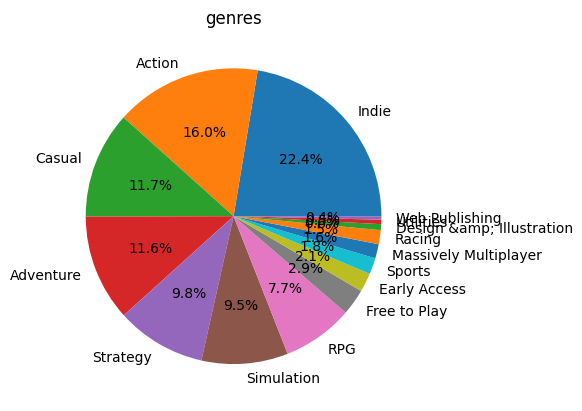

In [37]:
showPie(juego_genero)

In [38]:
df_games['genres_tags'] = df_games['genres'] + df_games['tags']

In [39]:
df_games['genres_tags']	= df_games['genres_tags'].apply(lambda x: pd.Series(x).drop_duplicates().tolist())

In [40]:
df_games['genres_tags'].explode().fillna('Generic', inplace=True)

In [203]:
words = df_games['genres_tags'].explode().explode().dropna().values

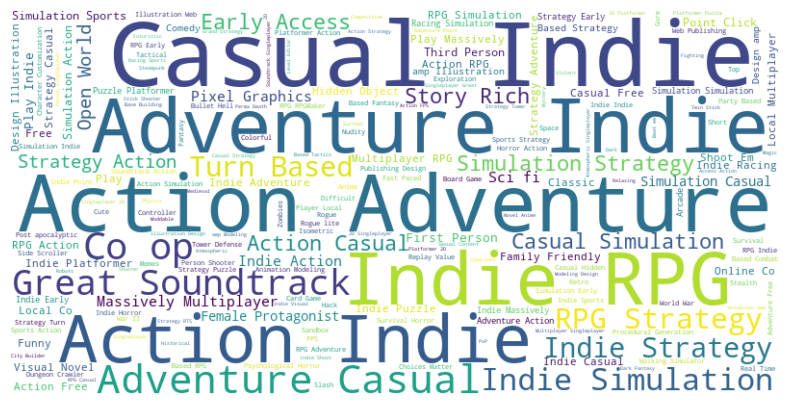

In [204]:

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(words))


plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [207]:
generos_tags = [[row['id_game'], *row['genres_tags']] for _, row in df_games.iterrows()]

tuplas = [[i[0], j] for i in generos_tags for j in i[1:]]

generos_tags[0]

[761140, 'Action', 'Casual', 'Indie', 'Simulation', 'Strategy']

In [43]:
df_juego_genero_tag = pd.DataFrame(tuplas, columns=['id_game', 'genero_tag'])

df_juego_genero_tag = df_juego_genero_tag.dropna().drop_duplicates().reset_index()

df_juego_genero_tag.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155983 entries, 0 to 155982
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   index       155983 non-null  int64 
 1   id_game     155983 non-null  int64 
 2   genero_tag  155983 non-null  object
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [44]:
# Elegimos el nro de generos para el dataset de análisis
nro_generos_tag = 30

In [45]:
recorte = df_juego_genero_tag['genero_tag'].value_counts().reset_index().head(nro_generos_tag)
df_juego_genero_tag_recortado = df_juego_genero_tag[df_juego_genero_tag.genero_tag.isin(recorte['genero_tag'])]
df_juego_genero_tag_recortado = df_juego_genero_tag_recortado.dropna().drop_duplicates().drop('index', axis=1).reset_index(drop=True)

In [47]:
matriz_dummies = pd.get_dummies(df_juego_genero_tag_recortado, dtype=int, prefix='gen')
matriz_dummies = matriz_dummies.groupby('id_game').sum()

In [49]:
filter_games_df = None

items_reviews_filter = False

if items_reviews_filter:
    items_unicos = pd.read_csv('id_items_unicos.csv')
    items_unicos.columns = ['index', 'id_game']
    # matriz_dummies = pd.merge(matriz_dummies, items_unicos,left_on='id_juego', right_on='id_juego')
    filter_games_df = items_unicos

In [50]:
stats_filter = True

if stats_filter:
    stats = pd.read_csv('df_games_stats_user.csv')
    # stats.set_index('item_id', inplace=True)
    # stats.rename_axis('id_juego', inplace=True)
    stats  = stats.rename({'item_id': 'id_game'}, axis=1)
    filter_games_df = stats
    print(stats.iloc[0])

user_id             -AnimeIsMyThing-
id_game                        10090
playtime_forever                1373
playtime_2weeks                    0
total_play                      1373
Name: 0, dtype: object


In [51]:
filter_games_df = filter_games_df.groupby('id_game').sum('playtime_forever').query('playtime_forever > 0')
filter_games_df

,playtime_forever,playtime_2weeks,total_play
id_game,,,
10,2106016,21209,2127225
20,168263,13071,181334
30,158986,13019,172005
40,4389,27,4416
50,96324,323,96647
...,...,...,...
524600,9,9,18
526240,14,14,28
527340,418,418,836


In [52]:
if filter_games_df is not None and not filter_games_df.empty:
    matriz_dummies_filtrada = pd.merge(matriz_dummies, filter_games_df, left_on='id_game', right_on='id_game')

matriz_dummies_filtrada

,gen_2D,gen_Action,gen_Adventure,gen_Anime,gen_Atmospheric,gen_Casual,gen_Co-op,gen_Difficult,gen_Early Access,gen_Fantasy,...,gen_Sci-fi,gen_Shooter,gen_Simulation,gen_Singleplayer,gen_Sports,gen_Story Rich,gen_Strategy,playtime_forever,playtime_2weeks,total_play
id_game,,,,,,,,,,,,,,,,,,,,,
10,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,2106016,21209,2127225
20,0,1,1,0,0,1,1,0,0,0,...,0,1,0,0,0,1,0,168263,13071,181334
30,0,1,0,0,0,0,1,0,0,0,...,0,1,0,1,0,0,0,158986,13019,172005
40,0,1,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,4389,27,4416
50,0,1,1,0,1,0,1,0,0,0,...,1,1,0,1,0,1,0,96324,323,96647
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
523760,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,63,63,126
524600,0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,9,9,18
527340,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,418,418,836


In [53]:
df_games.genres.explode().rename_axis('id_game')


id_game
761140        Action
761140        Casual
761140         Indie
761140    Simulation
761140      Strategy
             ...    
610660        Racing
610660    Simulation
658870        Casual
658870         Indie
681550          None
Name: genres, Length: 74833, dtype: object

In [54]:
stats

,user_id,id_game,playtime_forever,playtime_2weeks,total_play
0,-AnimeIsMyThing-,10090,1373,0,1373
1,-AnimeIsMyThing-,102600,4,0,4
2,-AnimeIsMyThing-,105600,4028,0,4028
3,-AnimeIsMyThing-,108710,79,79,158
4,-AnimeIsMyThing-,109600,1343,0,1343
...,...,...,...,...,...
685381,zyxwvutsrqponm,730,38179,372,38551
685382,zyxwvutsrqponm,8140,0,0,0
685383,zyxwvutsrqponm,8870,541,0,541
685384,zyxwvutsrqponm,8930,11827,0,11827


In [55]:
stats = stats.rename({'item_id': 'id_game'}, axis=1)
stats

,user_id,id_game,playtime_forever,playtime_2weeks,total_play
0,-AnimeIsMyThing-,10090,1373,0,1373
1,-AnimeIsMyThing-,102600,4,0,4
2,-AnimeIsMyThing-,105600,4028,0,4028
3,-AnimeIsMyThing-,108710,79,79,158
4,-AnimeIsMyThing-,109600,1343,0,1343
...,...,...,...,...,...
685381,zyxwvutsrqponm,730,38179,372,38551
685382,zyxwvutsrqponm,8140,0,0,0
685383,zyxwvutsrqponm,8870,541,0,541
685384,zyxwvutsrqponm,8930,11827,0,11827


In [56]:
df_ex = df_games.genres.explode().rename_axis('id_game').reset_index()

In [57]:
stats

,user_id,id_game,playtime_forever,playtime_2weeks,total_play
0,-AnimeIsMyThing-,10090,1373,0,1373
1,-AnimeIsMyThing-,102600,4,0,4
2,-AnimeIsMyThing-,105600,4028,0,4028
3,-AnimeIsMyThing-,108710,79,79,158
4,-AnimeIsMyThing-,109600,1343,0,1343
...,...,...,...,...,...
685381,zyxwvutsrqponm,730,38179,372,38551
685382,zyxwvutsrqponm,8140,0,0,0
685383,zyxwvutsrqponm,8870,541,0,541
685384,zyxwvutsrqponm,8930,11827,0,11827


In [58]:
stats = pd.read_csv('df_games_stats_user.csv').rename({'item_id': 'id_game'}, axis=1)
pd.merge(stats, df_ex, left_on='id_game', right_on='id_game').groupby(['user_id', 'genres']).sum()

id_game  playtime_forever  playtime_2weeks  \
user_id        genres                                                     
765611980577   Action        4740090               929                0   
               Adventure      634240               125                0   
               Casual         609320               743                0   
               Early Access   391460                 1                0   
               Free to Play  4071880               600                0   
...                              ...               ...              ...   
zyxwvutsrqponm RPG           1494150              7691                0   
               Simulation    1462520              5423                0   
               Sports          31280                43                0   
               Strategy      2042390             25265               44   
               Utilities      282660                 0                0   

                             total_play  
user_id        genres                    
765611980577   Action               929  
               Adventure            125  
               Casual               743  
               Early Access           1  
               Free to Play         600  
...                                 ...  
zyxwvutsrqponm RPG                 7691  
               Simulation          5423  
               Sports                43  
               Strategy           25309  
               Utilities              0  

[69580 rows x 4 columns]

In [59]:
all_genres = df_games['genres'].explode().rename_axis('id_game')

In [60]:
all_years = df_games[ 'release_year'].explode().rename_axis('id_game')

In [61]:
genre_year = pd.merge(all_genres, all_years, left_on='id_game', right_on='id_game')

In [62]:
genre_year.head(5)

,genres,release_year
id_game,,
761140,Action,2018
761140,Casual,2018
761140,Indie,2018
761140,Simulation,2018
761140,Strategy,2018


In [63]:
year_user_genre = pd.merge(stats, genre_year, left_on='id_game', right_on='id_game').groupby(['release_year','user_id', 'genres']).sum(['playtime_forever'])

In [64]:
matriz_generos = pd.merge(pd.DataFrame(all_genres), filter_games_df, left_on='id_game', right_on='id_game')

In [65]:
matriz_generos

,genres,playtime_forever,playtime_2weeks,total_play
id_game,,,,
282010,Action,1577,0,1577
282010,Indie,1577,0,1577
282010,Racing,1577,0,1577
70,Action,334490,1544,336034
1640,Strategy,3030,0,3030
...,...,...,...,...
200980,Strategy,471,0,471
200980,RPG,471,0,471
200980,Indie,471,0,471


In [66]:
df_games_join = df_games[['genres', 'release_year', 'id_game']]

In [67]:
genero_estadisticas = pd.merge(matriz_generos, df_games_join, left_on='id_game', right_on='id_game').groupby(['genres_x', 'release_year']).sum('playtime_forever')
# genero_estadisticas = genero_estadisticas.drop(['genres_y'], axis=1)
# genero_estadisticas.drop(columns=['id', 'app_name', 'genres_y', 'release_date', 'tags', 'price', 'developer', 'genres_tags'], inplace=True)
genero_estadisticas.to_csv('generos_estadisticas.csv')
# genero_estadisticas.drop(columns=['id'], inplace=True)
genero_estadisticas

id_game  playtime_forever  playtime_2weeks  \
genres_x       release_year                                               
Action         1900           841650            560429             2244   
               1983           227380               597                0   
               1984           240340               109                0   
               1988           308000              2843                0   
               1989           302330                48                0   
...                              ...               ...              ...   
Web Publishing 2012           220700            431252            10626   
               2013           699790             74442              324   
               2014           587670              1344                0   
               2015          1806090            159463            19684   
               2017           234820               796                0   

                             total_play  
genres_x       release_year              
Action         1900              562673  
               1983                 597  
               1984                 109  
               1988                2843  
               1989                  48  
...                                 ...  
Web Publishing 2012              441878  
               2013               74766  
               2014                1344  
               2015              179147  
               2017                 796  

[342 rows x 4 columns]

In [68]:
# genero_estadisticas.reset_index().rename({'genres_x' : 'genre'}, axis=1)

In [69]:
genero_estadisticas = pd.read_csv('generos_estadisticas.csv')
genero_estadisticas = genero_estadisticas.set_index('genres_x')
genero_estadisticas

,release_year,id_game,playtime_forever,playtime_2weeks,total_play
genres_x,,,,,
Action,1900,841650,560429,2244,562673
Action,1983,227380,597,0,597
Action,1984,240340,109,0,109
Action,1988,308000,2843,0,2843
Action,1989,302330,48,0,48
...,...,...,...,...,...
Web Publishing,2012,220700,431252,10626,441878
Web Publishing,2013,699790,74442,324,74766
Web Publishing,2014,587670,1344,0,1344


In [70]:
genero_estadisticas = pd.read_csv('generos_estadisticas.csv')
genero_estadisticas = genero_estadisticas.set_index(['genres_x', 'release_year'])

In [71]:


genero_string = 'Casual'

año_maximo = genero_estadisticas.query(f"genres_x == '{genero_string}'")['playtime_forever'].sort_values(ascending=False).head(1)

pd.DataFrame(año_maximo).reset_index().release_year.values[0]

2015

In [72]:
matriz_dummies_filtrada

,gen_2D,gen_Action,gen_Adventure,gen_Anime,gen_Atmospheric,gen_Casual,gen_Co-op,gen_Difficult,gen_Early Access,gen_Fantasy,...,gen_Sci-fi,gen_Shooter,gen_Simulation,gen_Singleplayer,gen_Sports,gen_Story Rich,gen_Strategy,playtime_forever,playtime_2weeks,total_play
id_game,,,,,,,,,,,,,,,,,,,,,
10,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,2106016,21209,2127225
20,0,1,1,0,0,1,1,0,0,0,...,0,1,0,0,0,1,0,168263,13071,181334
30,0,1,0,0,0,0,1,0,0,0,...,0,1,0,1,0,0,0,158986,13019,172005
40,0,1,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,4389,27,4416
50,0,1,1,0,1,0,1,0,0,0,...,1,1,0,1,0,1,0,96324,323,96647
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
523760,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,63,63,126
524600,0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,9,9,18
527340,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,418,418,836


In [73]:
df_games.query('release_year > 2016')

,id_game,app_name,genres,release_date,tags,price,developer,release_year,genres_tags
index,,,,,,,,,
761140,761140,Lost Summoner Kitty,"[Action, Casual, Indie, Simulation, Strategy]",2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",4.99,Kotoshiro,2018,"[Action, Casual, Indie, Simulation, Strategy]"
643980,643980,Ironbound,"[Free to Play, Indie, RPG, Strategy]",2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",0.00,Secret Level SRL,2018,"[Free to Play, Indie, RPG, Strategy, Card Game..."
670290,670290,Real Pool 3D - Poolians,"[Casual, Free to Play, Indie, Simulation, Sports]",2017-07-24,"[Free to Play, Simulation, Sports, Casual, Ind...",0.00,Poolians.com,2017,"[Casual, Free to Play, Indie, Simulation, Spor..."
767400,767400,弹炸人2222,"[Action, Adventure, Casual]",2017-12-07,"[Action, Adventure, Casual]",0.99,彼岸领域,2017,"[Action, Adventure, Casual]"
772540,772540,Battle Royale Trainer,"[Action, Adventure, Simulation]",2018-01-04,"[Action, Adventure, Simulation, FPS, Shooter, ...",3.99,Trickjump Games Ltd,2018,"[Action, Adventure, Simulation, FPS, Shooter, ..."
...,...,...,...,...,...,...,...,...,...
745400,745400,Kebab it Up!,"[Action, Adventure, Casual, Indie]",2018-01-04,"[Action, Indie, Casual, Violent, Adventure]",1.99,Bidoniera Games,2018,"[Action, Adventure, Casual, Indie, Violent]"
773640,773640,Colony On Mars,"[Casual, Indie, Simulation, Strategy]",2018-01-04,"[Strategy, Indie, Casual, Simulation]",1.99,"Nikita ""Ghost_RUS""",2018,"[Casual, Indie, Simulation, Strategy]"
733530,733530,LOGistICAL: South Africa,"[Casual, Indie, Strategy]",2018-01-04,"[Strategy, Indie, Casual]",4.99,Sacada,2018,"[Casual, Indie, Strategy]"


In [74]:
# matriz_dummies_rev.to_csv('matriz_dummies_rev.csv')

In [75]:
# matriz_dummies.to_csv('md.csv')

In [76]:
# matriz_dummies.index = matriz_dummies.index.astype(int)

to_drop = matriz_dummies_filtrada.sum()[matriz_dummies_filtrada.sum() == 0].index.to_list()

matriz_dummies_filtrada.drop(to_drop, axis=1, inplace=True)

In [77]:
matriz_dummies_filtrada = matriz_dummies_filtrada.drop(['playtime_forever','playtime_2weeks',	'total_play'], axis=1)

In [78]:
# matriz_dummies.rename_axis('index', inplace=True)

In [79]:
# matriz_dummies.index = matriz_dummies.id_game.astype(int)

In [80]:
matriz_dummies_filtrada.columns

Index(['gen_2D', 'gen_Action', 'gen_Adventure', 'gen_Anime', 'gen_Atmospheric',
       'gen_Casual', 'gen_Co-op', 'gen_Difficult', 'gen_Early Access',
       'gen_Fantasy', 'gen_Female Protagonist', 'gen_Free to Play',
       'gen_Great Soundtrack', 'gen_Horror', 'gen_Indie',
       'gen_Massively Multiplayer', 'gen_Multiplayer', 'gen_Open World',
       'gen_Pixel Graphics', 'gen_Platformer', 'gen_Puzzle', 'gen_RPG',
       'gen_Racing', 'gen_Sci-fi', 'gen_Shooter', 'gen_Simulation',
       'gen_Singleplayer', 'gen_Sports', 'gen_Story Rich', 'gen_Strategy'],
      dtype='object')

In [81]:
# matriz_dummies = matriz_dummies.drop(matriz_dummies.columns[[0, -1, -2, -3]], axis=1)

In [82]:
matriz_dummies_filtrada.to_csv('matriz_dummies.csv')

In [83]:
matriz_dummies.sample(10)

,gen_2D,gen_Action,gen_Adventure,gen_Anime,gen_Atmospheric,gen_Casual,gen_Co-op,gen_Difficult,gen_Early Access,gen_Fantasy,...,gen_Puzzle,gen_RPG,gen_Racing,gen_Sci-fi,gen_Shooter,gen_Simulation,gen_Singleplayer,gen_Sports,gen_Story Rich,gen_Strategy
id_game,,,,,,,,,,,,,,,,,,,,,
206159,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
415350,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
316820,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
71164,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
366220,0,0,1,0,0,0,1,0,0,1,...,0,1,0,0,0,1,1,0,0,0
444760,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
454250,0,0,1,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
563282,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
449020,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [84]:
matriz_dummies_filtrada.to_csv('matriz_dummies_filtrada.csv')

In [85]:
matriz_dummies_filtrada.loc[400]

gen_2D                       0
gen_Action                   1
gen_Adventure                1
gen_Anime                    0
gen_Atmospheric              1
gen_Casual                   0
gen_Co-op                    0
gen_Difficult                0
gen_Early Access             0
gen_Fantasy                  0
gen_Female Protagonist       1
gen_Free to Play             0
gen_Great Soundtrack         1
gen_Horror                   0
gen_Indie                    0
gen_Massively Multiplayer    0
gen_Multiplayer              0
gen_Open World               0
gen_Pixel Graphics           0
gen_Platformer               1
gen_Puzzle                   1
gen_RPG                      0
gen_Racing                   0
gen_Sci-fi                   1
gen_Shooter                  0
gen_Simulation               0
gen_Singleplayer             1
gen_Sports                   0
gen_Story Rich               1
gen_Strategy                 1
Name: 400, dtype: int32

In [86]:
from sklearn.metrics.pairwise import cosine_similarity

def comparar(id_1, id_2):
    row1 = matriz_dummies_filtrada.loc[id_1].values.reshape(1,-1)
    row2 = matriz_dummies_filtrada.loc[id_2].values.reshape(1,-1)
    return cosine_similarity(row1, row2)    


In [87]:
def get_recommended(id_juego):
    lista = []
    # id_juego = matriz_dummies.sample().index

    for i in matriz_dummies_filtrada.index.tolist():
        if i != id_juego:
            (a, b) = i, comparar(id_juego, i)
            if 0.5 < b[0][0] <= 1:
                lista.append((a, b[0][0]))
    
    return pd.DataFrame(lista, columns=['id_juego', 'similitud']).sort_values('similitud', ascending=False).head(5)
    

In [88]:
id_juego = 400

# pd.DataFrame(lista, columns=['id_juego', 'similitud']).sort_values('similitud', ascending=False).head(5)

get_recommended(id_juego)

,id_juego,similitud
392,228300,0.904534
109,17410,0.904534
9,620,0.870388
472,245280,0.858116
97,15130,0.858116


In [89]:
# big = cosine_similarity(matriz_dummies,matriz_dummies)

In [90]:
# big[0:5, 0: 5]

In [91]:
# generos_filtrados = df_juego_genero_tag['genero_tag'].value_counts().head(50).reset_index().head(38)['genero_tag'].to_list()

In [92]:
# mask = df_juego_genero_tag['genero_tag'].isin(generos_filtrados)

In [93]:
# df_juego_genero_tag['genero_tag'][mask]

In [94]:
# a_clustear = pd.get_dummies(df_juego_genero_tag['genero_tag'][mask], dtype='int')

In [95]:
# a_clustear

In [96]:
df_games.query('id_game == 12500')

,id_game,app_name,genres,release_date,tags,price,developer,release_year,genres_tags
index,,,,,,,,,
12500,12500,PuzzleQuest: Challenge of the Warlords,[Casual],2007-10-10,"[Puzzle, Casual, Match 3, RPG, Fantasy, 2D, St...",9.99,Infinite Interactive,2007,"[Casual, Puzzle, Match 3, RPG, Fantasy, 2D, St..."


In [97]:
# from sklearn.cluster import KMeans
# import numpy as np

# # Assuming you have your data stored in a variable called 'data'

# # Create a KMeans instance with 38 clusters
# kmeans = KMeans(n_clusters=38)

# # Fit the KMeans model to your data
# kmeans.fit(a_clustear)

# # Get the cluster labels for each data point
# cluster_labels = kmeans.labels_

# # Get the cluster centers
# cluster_centers = kmeans.cluster_centers_

In [98]:
# preds = kmeans.predict(a_clustear)

# preds.shape

In [99]:
# df_games.query("release_year.notnull()")


In [100]:
# df_recortado['release_year'] = df_recortado['release_year'].astype(int)

In [101]:
# df_recortado.query("id == 12500")

In [102]:
# df_recortado.index = df_recortado.index.astype(int)

In [103]:
# df_recortado['id'] = df_recortado['id'].astype(int)

In [104]:
# df_recortado.drop('id', axis=1)

In [105]:
# items_unicos = pd.read_csv('id_items_unicos.csv')
# items_unicos.columns = ['index', 'id_juego']

# items_unicos

In [106]:
# df_recortado_2 = pd.merge(items_unicos, df_recortado.drop('id', axis=1), left_on='id_juego', right_on='id')

In [107]:
# df_recortado_2.query("app_name.str.contains('boid')")


In [108]:
# lista_comp = []
# for i in matriz_dummies.index:
#     temp = []
#     for j in matriz_dummies.index:
#         temp.append(comparar(i,j))
#     lista_comp.append(temp)


In [109]:
# matriz = pd.DataFrame(lista_comp)

# matriz.to_csv('matrizon.csv')

In [110]:
# import numpy as np

# # Definir la función comparar
# def comparar(X, Y):
#     # Ejemplo de función de comparación (suma en este caso)
#     return X + Y

# # Ejemplo de matrices A y B
# A = np.array([[1, 2, 3],
#               [2, 4, 5],
#               [3, 5, 6]])

# B = np.array([[4, 5, 6],
#               [5, 7, 8],
#               [6, 8, 9]])

# # Inicializar matriz de resultados
# result = np.zeros_like(A)

# # Calcular las operaciones en la parte triangular superior
# for i in range(A.shape[0]):
#     for j in range(i, A.shape[1]):
#         # Realizar la operación simétrica
#         operation_result = comparar(A[i, j], B[i, j])
#         # Reflejar el resultado en la parte opuesta
#         result[i, j] = operation_result
#         result[j, i] = operation_result

# print("Resultado:")
# print(result)


In [111]:
matriz_dummies_filtrada = pd.read_csv('matriz_dummies_filtrada.csv', index_col='id_game')

def comparar(id_1, id_2, matriz):
    row1 = matriz.loc[id_1].values.reshape(1, -1)
    row2 = matriz.loc[id_2].values.reshape(1, -1)
    return cosine_similarity(row1, row2)    


lista = []
id_game = matriz_dummies_filtrada.sample().index

# if id_juego not in matriz_dummies:
#     return {'message' : 'game_id not found!!!'}

for i in matriz_dummies_filtrada.index.tolist():
    if i != id_juego:
        (a, b) = i, comparar(id_game, i, matriz_dummies_filtrada)
        if 0.5 < b[0][0] <= 1:
            lista.append((a, b[0][0]))

juegos_rec = pd.DataFrame(lista, columns=['id_juego', 'similitud']).sort_values('similitud', ascending=False).head(5)

In [112]:
juegos_rec

,id_juego,similitud
961,368680,0.866025
1448,482120,0.866025
1006,375030,0.866025
254,243280,0.866025
607,314570,0.866025


## 1.2 User Items

#### 1. Cargamos el contenido del Archivo User's Items en un arreglo de líneas con codigo JSON en formato de String

In [113]:
df_games.query("id_game == 440")

,id_game,app_name,genres,release_date,tags,price,developer,release_year,genres_tags
index,,,,,,,,,
440,440,Team Fortress 2,"[Action, Free to Play]",2007-10-10,"[Free to Play, Multiplayer, FPS, Action, Shoot...",0.0,Valve,2007,"[Action, Free to Play, Multiplayer, FPS, Shoot..."


In [114]:
lines_items = []
json_lines_items = []

with open(URL_USERS_ITEMS, 'r', encoding='utf-8') as f_items:
    for line in f_items:
        lines_items.append(line)

In [115]:
len(lines_items)

88310

In [116]:
linea_1 = json.dumps(ast.literal_eval(lines_items[0]))

In [117]:
json_linea_1 = json.dumps(ast.literal_eval(linea_1))

In [118]:
pd.read_json(json_linea_1, lines=True)

,user_id,items_count,steam_id,user_url,items
0,76561197970982480,277,76561197970982480,http://steamcommunity.com/profiles/76561197970...,"[{'item_id': '10', 'item_name': 'Counter-Strik..."


In [119]:
dt_linea_1 = pd.DataFrame(ast.literal_eval(linea_1)['items'])
dt_linea_1['user_id'] = '76561197970982480'
dt_linea_1

,item_id,item_name,playtime_forever,playtime_2weeks,user_id
0,10,Counter-Strike,6,0,76561197970982480
1,20,Team Fortress Classic,0,0,76561197970982480
2,30,Day of Defeat,7,0,76561197970982480
3,40,Deathmatch Classic,0,0,76561197970982480
4,50,Half-Life: Opposing Force,0,0,76561197970982480
...,...,...,...,...,...
272,289130,Endless Legend,593,0,76561197970982480
273,268500,XCOM 2,1495,0,76561197970982480
274,461640,Sins Of The Demon RPG,0,0,76561197970982480
275,379720,DOOM,793,0,76561197970982480


In [120]:
json_lines_items = []

In [121]:
json_lines_items = []

for i, linea in enumerate(lines_items):
  try:
    json_lines_items.append(json.dumps(ast.literal_eval(linea)))
  except:
    pass


In [122]:
len(json_lines_items)

88310

In [123]:
# df_users_stats = pd.read_json("\n".join(lines_items), lines=True)

# df_users_stats = pd.read_json("\n".join(lines_items), lines=True)

In [124]:
dfs = []

# Read JSON lines in chunks of 5000 lines each
chunksize = 5000
for chunk in range(0, len(json_lines_items), chunksize):
    chunk_data = "\n".join(json_lines_items[chunk:chunk + chunksize])
    df_chunk = pd.read_json(chunk_data, lines=True)
    dfs.append(df_chunk)

# Concatenate the DataFrames into a single DataFrame
df_users_stats = pd.concat(dfs, ignore_index=True)

In [125]:
df_users_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88310 entries, 0 to 88309
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      88310 non-null  object
 1   items_count  88310 non-null  int64 
 2   steam_id     88310 non-null  int64 
 3   user_url     88310 non-null  object
 4   items        88310 non-null  object
dtypes: int64(2), object(3)
memory usage: 3.4+ MB


In [126]:
lista = []

for i in range(df_users_stats.shape[0]):
  id_usuario = df_users_stats.iloc[i,0]
  dic = df_users_stats.iloc[i,4]
  for j, it in enumerate(dic):
    item_id = dic[j]['item_id']
    item_name = dic[j]['item_name']
    item_play_time = dic[j]['playtime_forever']
    item_pt2 = dic[j]['playtime_2weeks']
    tupla = (id_usuario, item_id, item_name, item_play_time, item_pt2)
    lista.append(tupla)

In [127]:
len(lista)

5153209

In [128]:
columnas = ['user_id','item_id', 'item_name', 'playtime_forever', 'playtime_2weeks']

In [129]:
df_usuarios_est = pd.DataFrame(lista, columns=columnas)

In [130]:
df_usuarios_est

,user_id,item_id,item_name,playtime_forever,playtime_2weeks
0,76561197970982479,10,Counter-Strike,6,0
1,76561197970982479,20,Team Fortress Classic,0,0
2,76561197970982479,30,Day of Defeat,7,0
3,76561197970982479,40,Deathmatch Classic,0,0
4,76561197970982479,50,Half-Life: Opposing Force,0,0
...,...,...,...,...,...
5153204,76561198329548331,346330,BrainBread 2,0,0
5153205,76561198329548331,373330,All Is Dust,0,0
5153206,76561198329548331,388490,One Way To Die: Steam Edition,3,3
5153207,76561198329548331,521570,You Have 10 Seconds 2,4,4


In [131]:
df_usuarios_est = df_usuarios_est[['user_id', 'item_id', 'playtime_forever']].query("playtime_forever > 1440")

In [132]:
# df_usuarios_est['total_play'] = df_usuarios_est['playtime_forever'] + df_usuarios_est['playtime_2weeks']

In [133]:
df_usuarios_est.groupby(['user_id', 'item_id']).sum().to_csv('df_games_stats_user_item.csv')

In [134]:
df_usuarios_est.item_id = df_usuarios_est.item_id.astype(int)

In [135]:
df_usuarios_est

,user_id,item_id,playtime_forever
8,76561197970982479,300,4733
9,76561197970982479,240,1853
16,76561197970982479,6910,2685
41,76561197970982479,17460,1613
46,76561197970982479,1250,10006
...,...,...,...
5152638,76561198312638244,362890,2184
5152651,76561198313357718,730,2317
5152652,POMFP0MF,730,2987
5152671,76561198319916652,370240,1533


<Axes: xlabel='playtime_forever', ylabel='Count'>

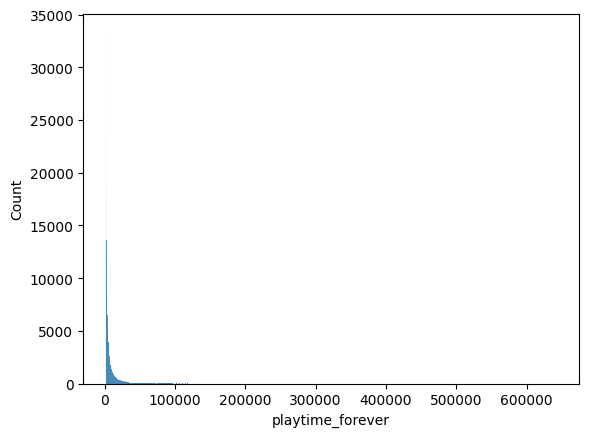

In [136]:
sns.histplot(df_usuarios_est.playtime_forever)

In [137]:
all_genres

id_game
761140        Action
761140        Casual
761140         Indie
761140    Simulation
761140      Strategy
             ...    
610660        Racing
610660    Simulation
658870        Casual
658870         Indie
681550          None
Name: genres, Length: 74833, dtype: object

In [138]:
df = df_usuarios_est.groupby('user_id').sum().sort_values(by='playtime_forever', ascending=False)


In [139]:
mas_jugadores = df.head(1000).index

In [140]:
df_usuarios_est[df_usuarios_est.sort_values(by='playtime_forever', ascending=False).user_id.isin(mas_jugadores.values)]

,user_id,item_id,playtime_forever
4641,thequeenpanda,240,6886
4645,thequeenpanda,4000,255613
4665,thequeenpanda,500,71580
4666,thequeenpanda,9480,12041
4670,thequeenpanda,33910,1524
...,...,...,...
5091118,76561198101480347,208090,3016
5091126,76561198101480347,7670,1564
5091130,76561198101480347,266210,19923
5091133,76561198101480347,335050,2437


In [141]:
df = df_usuarios_est[df_usuarios_est.sort_values(by='playtime_forever', ascending=False).user_id.isin(mas_jugadores.values)].sort_values(by='playtime_forever', ascending = False)
df

,user_id,item_id,playtime_forever
587715,wolop,4000,642773
2499068,Evilutional,212200,635295
4075729,76561198019826668,42710,632452
1495340,76561198039832932,4000,613411
1836985,tsunamitad,72200,600068
...,...,...,...
1898286,pjc001,19680,1441
3408761,skaeren2190,2820,1441
486122,uzicide,333930,1441
387375,rinco69,210770,1441


In [142]:
df = df_usuarios_est[df_usuarios_est.sort_values(by='playtime_forever', ascending=False).user_id.isin(mas_jugadores.values)].sort_values(by='playtime_forever', ascending = False)
df.rename({'item_id': 'id_game'}, axis=1, inplace=True)

pd.merge(all_genres, df, left_on='id_game', right_on='id_game').groupby(['user_id', 'genres']).sum().sort_values('playtime_forever', ascending=False).drop(['id_game'], axis=1).to_csv('user_genre_playtime.csv')

In [143]:
mas_jugadores = pd.merge(all_genres, df, left_on='id_game', right_on='id_game').groupby(['user_id']).sum().sort_values('playtime_forever', ascending=False).drop(['id_game'], axis=1)
mas_jugadores

,genres,playtime_forever
user_id,,
REBAS_AS_F-T,IndieSimulationActionRPGActionRPGIndieActionCa...,9034665
shinomegami,IndieSimulationStrategyActionSimulationStrateg...,7995508
Evilutional,ActionRPGStrategyActionActionAdventureCasualFr...,5000267
Sp3ctre,IndieSimulationActionRPGActionAdventureActionA...,4851206
tobscene,CasualActionRPGIndieStrategyRPGStrategyActionA...,4357726
...,...,...
76561198002872696,IndieSimulationStrategyActionIndieRPGStrategyA...,46205
76561198041008266,StrategyActionStrategyStrategyActionSimulation...,39484
SYSTEMK,ActionAction,29805


In [144]:
usuario_genero = pd.merge(all_genres, df, left_on='id_game', right_on='id_game').groupby(['user_id', 'genres']).sum().sort_values('playtime_forever', ascending=False).drop(['id_game'], axis=1)
usuario_genero.to_csv('usuario_genero.csv')


In [145]:
usuario_genero.query('genres == "Strategy"')

,,playtime_forever
user_id,genres,
shinomegami,Strategy,1109819
76561198038513068,Strategy,603053
76561198063368177,Strategy,591117
rinco69,Strategy,581291
streetjimmy,Strategy,547705
...,...,...
76561198016750146,Strategy,1565
omnixbro,Strategy,1554
johnvu3,Strategy,1548


In [146]:
merged_1 = pd.merge(all_genres, df, left_on='id_game', right_on='id_game')
merged_2 = pd.merge(merged_1, df_games[['id_game','release_year']], left_on='id_game', right_on='id_game').groupby(['user_id', 'genres', 'release_year']).sum().sort_values('playtime_forever', ascending=False).drop(['id_game'], axis=1)
# merged_2 = merged_2.head(10000)
merged_2
merged_2.to_csv('merged_2.csv')
merged_2.query("user_id =='archy18' and genres == 'Strategy'")

playtime_forever
user_id genres   release_year                  
archy18 Strategy 2012                     31625
                 2010                     30801
                 2013                     26536
                 2014                     23461
                 2009                     22951
                 2011                     22564
                 2015                     19111
                 2016                     15972
                 2003                     15643
                 2007                     15403
                 2006                     11912
                 2004                      5523
                 1999                      5341
                 2001                      3996
                 2008                      3911
                 2005                      3187
                 2000                      2436
                 1997                      1859

## 1.3 Reviews

In [147]:
URL_USERS_REVIEWS

'datasets/origin/australian_user_reviews.json'

In [148]:
lines_r = []

with open(URL_USERS_REVIEWS, 'rt', encoding= 'utf-8') as rev_file:
  for i, line in enumerate(rev_file):
    lines_r.append(ast.literal_eval(line))


In [149]:
df_revs = pd.DataFrame(lines_r)

In [150]:
columnas: List[str] = ['id_usuario', 'funny', 'posted', 'last_edited', 'item_id', 'helpful', 'recommend', 'review']

In [151]:
columnas = ['id_usuario']
columnas.extend(df_revs.reviews[0][0].keys())

In [152]:
lista_revs = []

for i in df_revs.index:
  id_usuario = df_revs.loc[i, 'user_id']
  dic = df_revs.loc[i, 'reviews']
  for it in dic:
    tupla = [id_usuario,*it.values()]
    lista_revs.append(tupla)

In [153]:
df_revs = pd.DataFrame(lista_revs, columns=columnas)

In [154]:
pd.Series(df_revs.item_id.unique()).to_csv('id_items_unicos.csv')

In [155]:
nltk.download('vader_lexicon')

# Initialize the VADER sentiment analyzer
sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\javier\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [156]:
df_revs['review_score'] = df_revs['review'].apply(lambda x: sid.polarity_scores(x)['compound'])
df_revs['review_sent'] = df_revs.review_score.apply(lambda x: 0 if x < 0 else (2 if x > 0 else 1))

df_revs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59305 entries, 0 to 59304
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id_usuario    59305 non-null  object 
 1   funny         59305 non-null  object 
 2   posted        59305 non-null  object 
 3   last_edited   59305 non-null  object 
 4   item_id       59305 non-null  object 
 5   helpful       59305 non-null  object 
 6   recommend     59305 non-null  bool   
 7   review        59305 non-null  object 
 8   review_score  59305 non-null  float64
 9   review_sent   59305 non-null  int64  
dtypes: bool(1), float64(1), int64(1), object(7)
memory usage: 4.1+ MB


In [157]:
df_revs_clean = df_revs[['id_usuario', 'funny', 'posted','item_id', 'recommend', 'helpful', 'review_sent']]

df_revs_clean['year'] = df_revs_clean.posted.astype('str')
df_revs_clean['year'] = df_revs_clean.year.apply(lambda x: x.split('-')[0])

In [158]:
df_revs_clean.drop('posted', axis=1)

,id_usuario,funny,item_id,recommend,helpful,review_sent,year
0,76561197970982479,,1250,True,No ratings yet,2,"Posted November 5, 2011."
1,76561197970982479,,22200,True,No ratings yet,2,"Posted July 15, 2011."
2,76561197970982479,,43110,True,No ratings yet,2,"Posted April 21, 2011."
3,js41637,,251610,True,15 of 20 people (75%) found this review helpful,2,"Posted June 24, 2014."
4,js41637,,227300,True,0 of 1 people (0%) found this review helpful,2,"Posted September 8, 2013."
...,...,...,...,...,...,...,...
59300,76561198312638244,,70,True,No ratings yet,2,Posted July 10.
59301,76561198312638244,,362890,True,No ratings yet,2,Posted July 8.
59302,LydiaMorley,1 person found this review funny,273110,True,1 of 2 people (50%) found this review helpful,2,Posted July 3.
59303,LydiaMorley,,730,True,No ratings yet,2,Posted July 20.


In [159]:
df_revs_clean.to_csv('revs.csv', index=False)

In [160]:
df_revs_clean.to_parquet('revs.parquet', index=False)

In [161]:
# %pip install pyarrow

In [162]:
item_revs = df_revs_clean.groupby(['item_id']).count()['id_usuario'].sort_values(ascending=False)

In [163]:
df_item_revs = pd.DataFrame(item_revs)

(array([843., 328., 197.,  66.,  96.,  75.,  29.,  46.,  57.,  35.]),
 array([ 2. ,  3.7,  5.4,  7.1,  8.8, 10.5, 12.2, 13.9, 15.6, 17.3, 19. ]),
 <BarContainer object of 10 artists>)

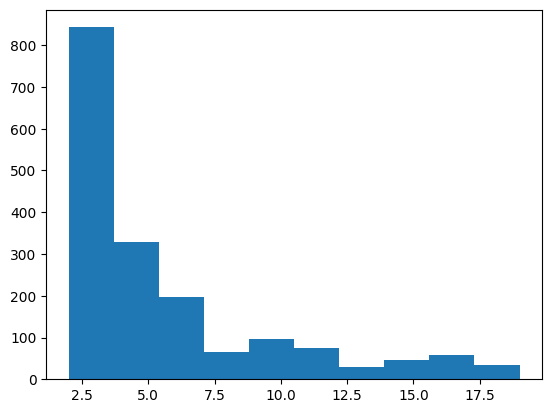

In [164]:
plt.hist(df_item_revs[(df_item_revs.id_usuario<20) & (df_item_revs.id_usuario>1) ].id_usuario)

In [165]:
df_item_revs

,id_usuario
item_id,
730,3759
440,3736
4000,1735
570,1562
218620,1137
...,...
342620,1
233310,1
342370,1


In [166]:
df_revs_item_year = df_revs_clean.groupby(['item_id', 'year']).count()['id_usuario'].sort_values(ascending=False).reset_index()

In [167]:
year = 2011
item = 1250
df_revs_item_year.query(f"year == '{year}' and item_id == '{item}'")

,item_id,year,id_usuario


In [168]:
df_revs_clean.drop('posted', axis=1)

,id_usuario,funny,item_id,recommend,helpful,review_sent,year
0,76561197970982479,,1250,True,No ratings yet,2,"Posted November 5, 2011."
1,76561197970982479,,22200,True,No ratings yet,2,"Posted July 15, 2011."
2,76561197970982479,,43110,True,No ratings yet,2,"Posted April 21, 2011."
3,js41637,,251610,True,15 of 20 people (75%) found this review helpful,2,"Posted June 24, 2014."
4,js41637,,227300,True,0 of 1 people (0%) found this review helpful,2,"Posted September 8, 2013."
...,...,...,...,...,...,...,...
59300,76561198312638244,,70,True,No ratings yet,2,Posted July 10.
59301,76561198312638244,,362890,True,No ratings yet,2,Posted July 8.
59302,LydiaMorley,1 person found this review funny,273110,True,1 of 2 people (50%) found this review helpful,2,Posted July 3.
59303,LydiaMorley,,730,True,No ratings yet,2,Posted July 20.


In [169]:
df_revs.funny = df_revs.funny.apply(limpiar_funny)
df_revs.helpful = df_revs.helpful.apply(limpiar_helpful)
df_revs.posted = df_revs.posted.apply(limpiar_posted)
df_revs.recommend = df_revs.recommend.map({True: 1, False: 0})

In [170]:
df_revs.head(5)

,id_usuario,funny,posted,last_edited,item_id,helpful,recommend,review,review_score,review_sent
0,76561197970982479,0,2011-11-05,,1250,1.00,1,Simple yet with great replayability. In my opi...,0.8481,2
1,76561197970982479,0,2011-07-15,,22200,1.00,1,It's unique and worth a playthrough.,0.2263,2
2,76561197970982479,0,2011-04-21,,43110,1.00,1,Great atmosphere. The gunplay can be a bit chu...,0.9117,2
3,js41637,0,2014-06-24,,251610,0.75,1,I know what you think when you see this title ...,0.9566,2
4,js41637,0,2013-09-08,,227300,0.00,1,For a simple (it's actually not all that simpl...,0.9708,2


In [171]:
df_revs['year_posted'] = df_revs.posted.dt.year

In [172]:
df_revs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59305 entries, 0 to 59304
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id_usuario    59305 non-null  object        
 1   funny         59305 non-null  int64         
 2   posted        59305 non-null  datetime64[ns]
 3   last_edited   59305 non-null  object        
 4   item_id       59305 non-null  object        
 5   helpful       59305 non-null  float64       
 6   recommend     59305 non-null  int64         
 7   review        59305 non-null  object        
 8   review_score  59305 non-null  float64       
 9   review_sent   59305 non-null  int64         
 10  year_posted   59305 non-null  int32         
dtypes: datetime64[ns](1), float64(2), int32(1), int64(3), object(4)
memory usage: 4.8+ MB


In [173]:
df_revs_filtrada = df_revs[['item_id', 'year_posted', 'recommend', 'review_sent']]
df_revs_filtrada.to_csv('df_revs_filtrada.csv')
df_revs_filtrada.query("year_posted == 2016").groupby(['item_id', 'year_posted']).sum(['reviews_sent', 'recommend']).sort_values(by='recommend', ascending=False).head(3)

,,recommend,review_sent
item_id,year_posted,,
730,2016,649,1033
440,2016,252,439
4000,2016,150,244


In [174]:
df_revs

,id_usuario,funny,posted,last_edited,item_id,helpful,recommend,review,review_score,review_sent,year_posted
0,76561197970982479,0,2011-11-05,,1250,1.00,1,Simple yet with great replayability. In my opi...,0.8481,2,2011
1,76561197970982479,0,2011-07-15,,22200,1.00,1,It's unique and worth a playthrough.,0.2263,2,2011
2,76561197970982479,0,2011-04-21,,43110,1.00,1,Great atmosphere. The gunplay can be a bit chu...,0.9117,2,2011
3,js41637,0,2014-06-24,,251610,0.75,1,I know what you think when you see this title ...,0.9566,2,2014
4,js41637,0,2013-09-08,,227300,0.00,1,For a simple (it's actually not all that simpl...,0.9708,2,2013
...,...,...,...,...,...,...,...,...,...,...,...
59300,76561198312638244,0,2016-07-10,,70,1.00,1,a must have classic from steam definitely wort...,0.5574,2,2016
59301,76561198312638244,0,2016-07-08,,362890,1.00,1,this game is a perfect remake of the original ...,0.9786,2,2016
59302,LydiaMorley,1,2016-07-03,,273110,0.50,1,had so much fun plaing this and collecting res...,0.7827,2,2016
59303,LydiaMorley,0,2016-07-20,,730,1.00,1,:D,0.5106,2,2016


# Endpoints

def UsersWorstDeveloper( año : int ): Devuelve el top 3 de desarrolladoras con juegos MENOS recomendados por usuarios para el año dado. (reviews.recommend = False y comentarios negativos)
Ejemplo de retorno: [{"Puesto 1" : X}, {"Puesto 2" : Y},{"Puesto 3" : Z}]

In [175]:
df_revs_filtrada = pd.read_csv('df_revs_filtrada.csv').rename({'item_id': 'id_game'}, axis=1)

pd.merge(df_revs_filtrada[['year_posted','id_game','recommend','review_sent']], df_games[['id_game', 'developer']], left_on="id_game", right_on="id_game").groupby(['developer','year_posted']).sum(['recommend', 'review_sent']).sort_values('review_sent')[['recommend', 'review_sent']].to_csv('developer_year_rec.csv')


In [176]:
dev_rec = pd.read_csv('developer_year_rec.csv')

query = dev_rec.query("year_posted == 2015").head(3)

query
salida = [{f'Puesto {i+1}': str(row[0])} for i, row in enumerate(query.values)]
salida

[{'Puesto 1': 'Masthead Studios Ltd'},
 {'Puesto 2': 'Matt Kap,Nicalis, Inc.'},
 {'Puesto 3': 'MercurySteam'}]

def sentiment_analysis( empresa desarrolladora : str ): Según la empresa desarrolladora, se devuelve un diccionario con el nombre de la desarrolladora como llave y una lista con la cantidad total de registros de reseñas de usuarios que se encuentren categorizados con un análisis de sentimiento como valor.
Ejemplo de retorno: {'Valve' : [Negative = 182, Neutral = 120, Positive = 278]}

In [177]:
dev_rec.query("developer == 'Valve' and review_sent == 0")

,developer,year_posted,recommend,review_sent


In [178]:
df_revs.item_id = df_revs.item_id.astype(int)

In [179]:
df = pd.merge(df_revs[['item_id','review_sent']], df_games[['id_game','developer']], left_on='item_id', right_on='id_game').drop(['item_id','id_game'], axis=1).sort_values(by='developer')
df.dropna(inplace=True)
desarrollador = 'Valve'
negativas = df.query(f"developer == '{desarrollador}' and review_sent == 0").count().review_sent
neutrales = df.query(f"developer == '{desarrollador}'  and review_sent == 1").count().review_sent
positivas = df.query(f"developer == '{desarrollador}'  and review_sent == 2").count().review_sent

In [180]:
{'Negativas': negativas, 'Neutrales': neutrales, 'Positivas': positivas}

{'Negativas': 1134, 'Neutrales': 2387, 'Positivas': 6176}

In [181]:
df.to_csv('des_reviews_sent.csv')

In [182]:
desarrollador = 'Valve'

# Dictionary comprehension to count occurrences of each sentiment
sentiment_counts = {sentiment: sum(1 for index, row in df.iterrows() if row['developer'] == desarrollador and row['review_sent'] == sentiment) for sentiment in range(3)}

print(sentiment_counts)


{0: 1134, 1: 2387, 2: 6176}


In [183]:
df_rev_sent = pd.read_csv('datasets/des_reviews_sent.csv')
desarrollador = 'Valve'
negativas = df_rev_sent.query(f"developer == '{desarrollador}' and review_sent == 0").count().review_sent
neutrales = df_rev_sent.query(f"developer == '{desarrollador}'  and review_sent == 1").count().review_sent
positivas = df_rev_sent.query(f"developer == '{desarrollador}'  and review_sent == 2").count().review_sent
{'Negativas': negativas, 'Neutrales': neutrales, 'Positivas': positivas}

{'Negativas': 1134, 'Neutrales': 2387, 'Positivas': 6176}

In [184]:
pivot_df = df.pivot_table(index='developer', columns='review_sent', aggfunc='size', fill_value=0).query("developer == 'Valve'")

pivot_df.columns.name = None  # Remove the name of the columns
pivot_df.columns = ['Negative','Neutral','Positive']
pivot_df

,Negative,Neutral,Positive
developer,,,
Valve,1134,2387,6176


In [185]:
df_rev_sent.sample(5)

,Unnamed: 0,review_sent,developer
40059,48952,1,Valve
31262,30055,2,Smartly Dressed Games
27013,42977,2,Reakktor Studios
50253,13782,2,tobyfox
12307,5754,2,Facepunch Studios
